# Homework 3

*Fine-tune model to your dataset from HW02. Be sure to run the training on GPU. Export and donwload the model.*

*Create a free HuggingFace account. Try to run Gradio app that takes an image as input and outputs the predicted class first locally. Then deploy it into HuggingFace Spaces. CPU runtime is fine, you do not need GPU for this step.*

## GPU

In [1]:
import torch

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Dataset

Pull dataset from GitHub to Colab.

In [2]:
!git clone https://github.com/marcekovam/Data_science_practicum_2025.git

Cloning into 'Data_science_practicum_2025'...
remote: Enumerating objects: 619, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 619 (delta 8), reused 0 (delta 0), pack-reused 600 (from 1)
Receiving objects: 100% (619/619), 252.63 MiB | 48.09 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [3]:
# Go to repo and check the files in it
%cd Data_science_practicum_2025
!ls

/content/Data_science_practicum_2025
dataset				       Lesson2_HW.ipynb
Lesson1_A_Short_Intro_To_Python.ipynb  Lesson3_Finetuning.ipynb
Lesson2_Beginning.ipynb		       Lesson3_HW.ipynb
Lesson2_FashionMNIST_Dense.ipynb       README.md
Lesson2_FashionMNIST_SimpleCNN.ipynb


In [6]:
# Copy the dataset folder to parent directory
!cp -r dataset ../dataset

In [9]:
%cd ..

/content


In [10]:
# Delete the cloned repo folder
!rm -rf Data_science_practicum_2025

In [11]:
# See the folders
!ls

dataset  sample_data


Let's see an example of images in the dataset.

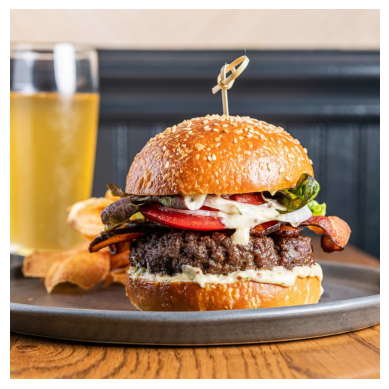

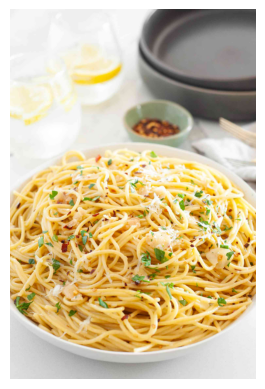

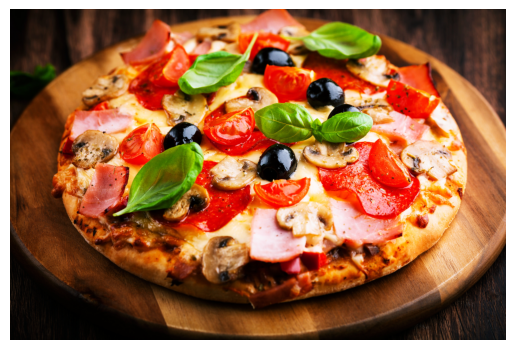

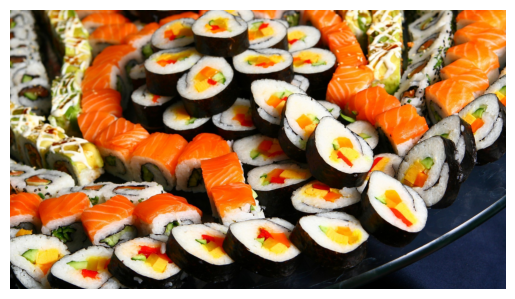

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

food = ['burger', 'pasta', 'pizza', 'sushi']
for jummy_meal in food:
  img_name = os.listdir(os.path.join("dataset/train", jummy_meal))[0]
  img = mpimg.imread("dataset/train/" + jummy_meal + "/" + img_name)
  plt.imshow(img)
  plt.axis("off")
  plt.show()

How many images are there in training and testing set?

In [13]:
train_num = {}
test_num = {}
for jummy_meal in food:
  train_num[jummy_meal] = len(os.listdir(os.path.join("dataset/train", jummy_meal)))
  test_num[jummy_meal] = len(os.listdir(os.path.join("dataset/test", jummy_meal)))

print("Train set counts:")
for jummy_meal, count in train_num.items():
    print(f"  {jummy_meal}: {count}")

print("Test set counts:")
for jummy_meal, count in test_num.items():
    print(f"  {jummy_meal}: {count}")

Train set counts:
  burger: 63
  pasta: 49
  pizza: 60
  sushi: 63
Test set counts:
  burger: 22
  pasta: 17
  pizza: 20
  sushi: 22


## Fine-tune model to the dataset

*Fine-tune model to your dataset from HW02. Be sure to run the training on GPU. Export and donwload the model.*

In [14]:
# There was an incompatibility issue with Gradio, that's why...
!pip uninstall fasttransform

Found existing installation: fasttransform 0.0.2
Uninstalling fasttransform-0.0.2:
  Would remove:
    /usr/local/lib/python3.12/dist-packages/fasttransform-0.0.2.dist-info/*
    /usr/local/lib/python3.12/dist-packages/fasttransform/*
Proceed (Y/n)? Y
  Successfully uninstalled fasttransform-0.0.2


In [ ]:
# Upgrade pip
!pip install --upgrade pip

# Install compatible versions
!pip install torch==2.2.1 torchvision==0.17.1
!pip install fastai==2.7.17 timm>=1.0.9

In [ ]:
!pip install numpy==1.26.4

### Dataloader (train data)

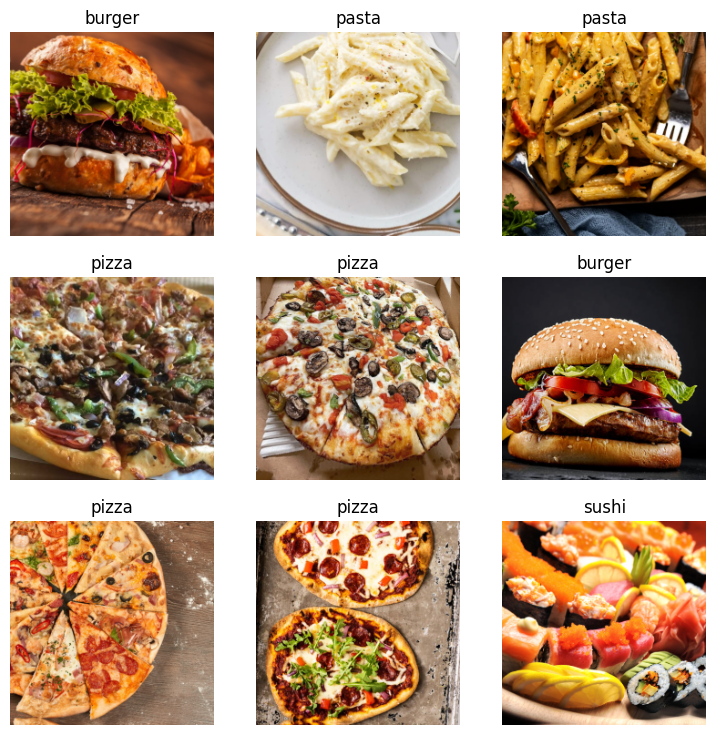

In [18]:
from fastai.vision.all import *
from pathlib import Path

path = Path('dataset/') / 'train'

dls = ImageDataLoaders.from_folder(
    path,                  # Path to the train folder
    train='.',             # Use the entire train folder for splitting
    valid_pct=0.2,         # 20% of the data will be used for validation
    seed=42,               # Set a seed for reproducibility
    item_tfms=Resize(460), # Resize the images to 460x460 (or your desired size)
    batch_tfms=aug_transforms(size=224, min_scale=0.75), # Data augmentation
    bs=64                  # Batch size 64
)

dls.show_batch(max_n=9)

Image-processing libraries may warn when a palette-based image with transparency is loaded. These warnings are usually harmless. The following code keeps my notebook clean without repetitive warnings.

In [19]:
import warnings

# To ignore the palette warnings
warnings.filterwarnings(
    "ignore",
    message="Palette images with Transparency expressed in bytes should be converted to RGBA images",
    category=UserWarning
)

### Train the model

* Choose a pretrained model.
* Determine the optimal learning rate using the learning rate finder.
* Fine-tune the pretrained model to adapt it to your dataset.

*Regarding the model, use rather something smaller from timm package. Architectures like convexnet, resnet, vgg or mobilenet should be fine.*

In [20]:
# Check models that are available
from timm import list_models
[model for model in list_models(pretrained=True) if model.find("convnext_tiny") != -1]

['convnext_tiny.fb_in1k',
 'convnext_tiny.fb_in22k',
 'convnext_tiny.fb_in22k_ft_in1k',
 'convnext_tiny.fb_in22k_ft_in1k_384',
 'convnext_tiny.in12k',
 'convnext_tiny.in12k_ft_in1k',
 'convnext_tiny.in12k_ft_in1k_384',
 'convnext_tiny_hnf.a2h_in1k']

I chose ConvNeXt, a convolutional neural network (CNN) designed for image recognition tasks.
The `convnext_tiny` version is the smallest variant with fewer layers and parameters, therefore, faster training. For small dataset it could be enough.

In [21]:
# Create a Learner object: data + model + metric during training
learn = vision_learner(dls, convnext_tiny, metrics=error_rate)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


`lr_find` from `fastai` runs a short training loop while gradually increases the learning rate and then it plots loss vs learning rate. The plot helps us find the optimal learning rate, where the loss is minimal or has the steepest slope.

SuggestedLRs(valley=0.0006918309954926372)

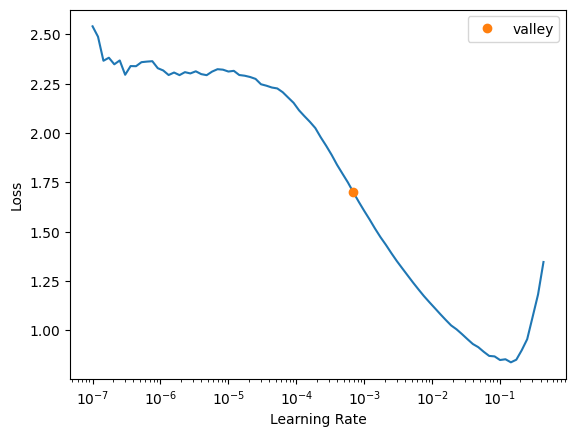

In [22]:
learn.lr_find()

How many epochs to choose?

* Small dataset (few thousand images) - 5–10 epochs could be enough
* Larger dataset (tens of thousands) - 10–20 epochs may be better
* Very small dataset (less than 1k images) - less epochs (3–5) to avoid overfitting

In [26]:
lr = 0.0006918309954926372 # optimal learning rate
epochs = 4 # number of one-cycles for training

Finally, fine-tune the model.

In [27]:
# Fine-tune the model
learn = vision_learner(dls, convnext_tiny, metrics=error_rate)
learn.fine_tune(epochs, lr)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluate the model's performance.

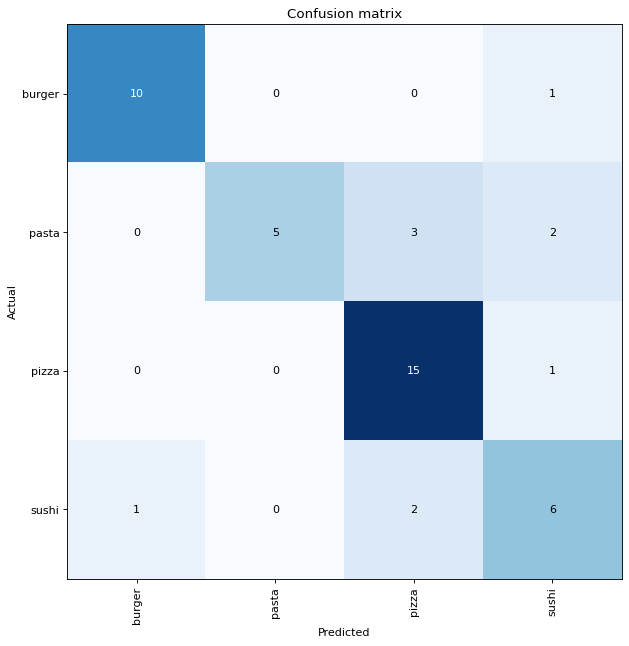

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8, 8), dpi=80)

Look at the misclassified images in the validation set.

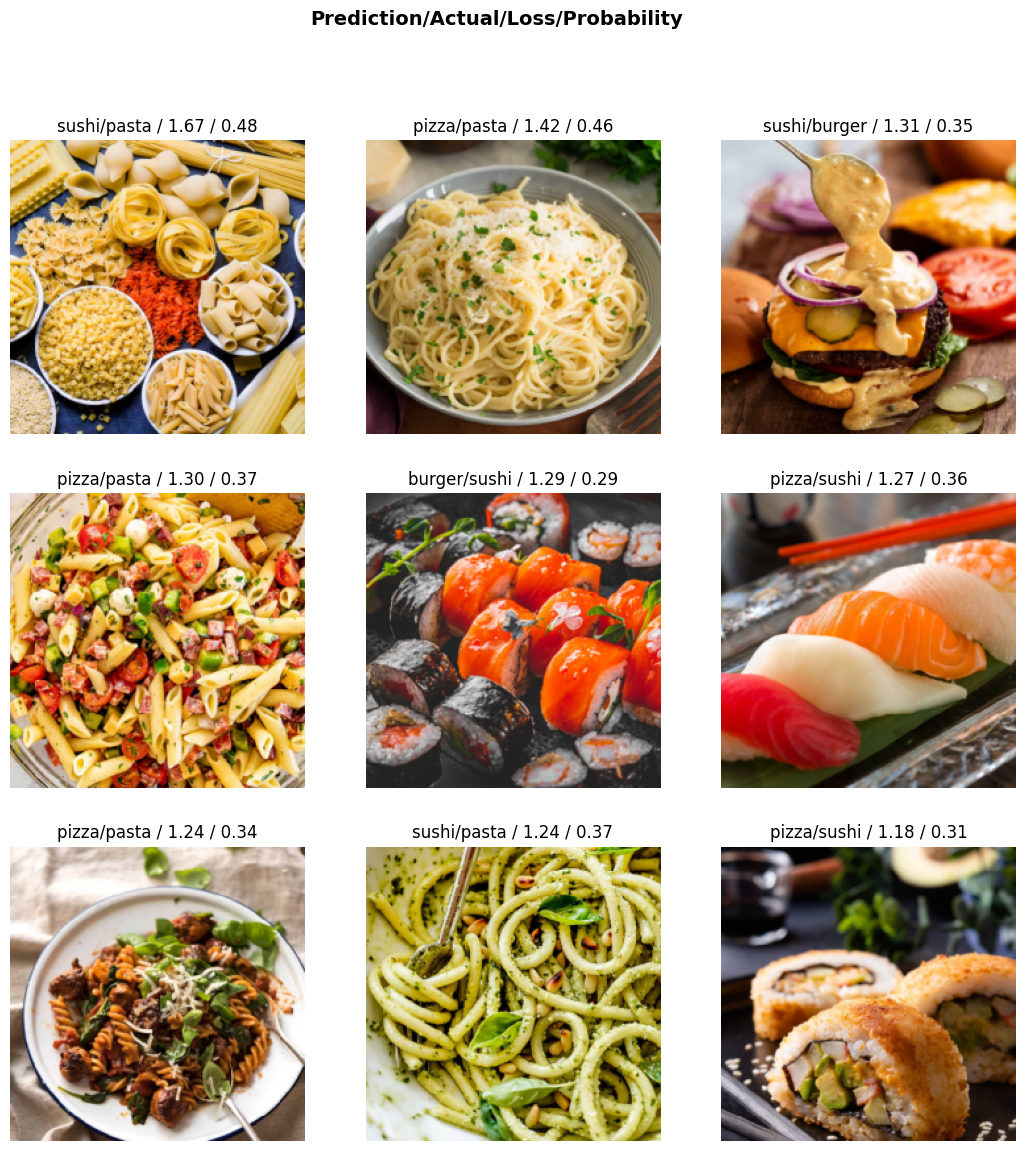

In [29]:
interp.plot_top_losses(9, figsize=(13,13))

If there is a mess, the data migh not be clean. There is a widget to clean the data. It lists the most suspicios images (highest loss) per set (train/valid) and category.

In [15]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

In [17]:
# Delete images
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
print(len(cleaner.delete()))

1


After deleting the images, rerun the entire notebook to update the dataloaders, as they will point to deleted files.

### Model performance on a test set

In [30]:
# Create a test DataLoader
test_path = Path('dataset/') / 'test'
test_dl = learn.dls.test_dl(get_image_files(test_path))

In [31]:
# Get predictions
preds, targets = learn.get_preds(dl=test_dl)
pred_labels = torch.argmax(preds, dim=1)

In [32]:
# Get class names
class_names = learn.dls.vocab
# Convert predictions to class names
pred_class_names = [class_names[i] for i in pred_labels]
true_class_names = [Path(t).parent.name for t in test_dl.items]

In [33]:
from statistics import mean

print("Test error rate:")
print(1 - mean([actual == predicted for actual, predicted in zip(true_class_names, pred_class_names)]))

Test error rate:
0.19753086419753085


It could be better, but, unfortunately, the dataset does not contain enough images to make this NN undefeatable.

### Save the model

Saving the model, so I can work with it later.

In [34]:
learn.export('model.pkl')
# learn = load_learner('./model.pkl')

## Gradio app

### Test the model on one image

Test the model on one image first to make sure it works well enough.

In [35]:
image_path = Path('/content/pizza.jpg')

# Predict the class of the new image
prediction, prediction_idx, probabilities = learn.predict(image_path)

# Print the prediction result
print(f'Prediction: {prediction}')
print(f'Index of the predicted class: {prediction_idx}')
print(f'Probabilities: {probabilities}')

Prediction: pizza
Index of the predicted class: 2
Probabilities: tensor([0.1109, 0.1067, 0.6453, 0.1371])


The result is ok.

### Run gradio locally

The cell below launches the Gradio interface locally.

In [36]:
# Importing Gradio for creating the web interface
import gradio as gr

# Extract categories (class labels) from the DataLoader
categories = learn.dls.vocab

# Function to classify an image
def classify_image(img):
    pred, idx, probs = learn.predict(img)
    return dict(zip(categories, map(float, probs)))  # Map categories to their probabilities

# Define Gradio input and output components using the updated API
image = gr.Image(width=224, height=224)  # Image input with fixed shape
label = gr.Label()  # Output label to display classification
examples = [image_path]  # Path to image(s) for demonstration

# Create and launch the Gradio interface
intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1cfde1fbcbc520eb63.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Deploy gradio app to 🤗 space

Create a free 🤗 account and log in. In the top left corner, click 'NEW', select Space, and fill out the short form. Choose Gradio for the Space SDK and make sure the space is set to Public. When your new space is created, select Files tab (top right corner). Now you should upload the following files into your space by clicking Upload files:

* `model.pkl`: your model
* `requirements.txt`: list of the packages needed to run the space
* `app.py`: the app itself
* `test_image1.jpg`, `test_image2.jpg`, etc.: examples of images

Except `model.pkl` and examples, you can get those files from https://github.com/simecek/dspracticum2024/tree/main/lesson03/gradio_app. Be sure to upload your `model.pkl`, and do not forget to check `app.py`. You will also need to modify examples `test_image1.jpg` and `test_image2.jpg`.

When the files are uploaded, the app will start building (see status Building, then Starting, then Running). Once building is complete, select the App tab (next to the Files tab) to actually use the app.

### Gradio app completed

The app is available at: https://huggingface.co/spaces/michaelam0503/Food_img_app

The most difficult part was in setting the versions of all libraries in `requirements.txt`. It took a few tries and checks in Colab. I had to change versions of libraries in Colab to make it compatible with Gradio, cause it has older version of Python than Colab.